In [1]:
import numpy as np
###list of data files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import math
from itertools import groupby
from operator import itemgetter
import more_itertools as mit
import time
from numpy import array
from numpy.random import rand
import datetime

In [2]:
def check_outlier(x):
    if x > 1.5 or x < -1.5:
        return "True"
    else:
        return "False"

In [3]:
def transfer_to_list_of_pd(clusters_list):
    clusters_data_list = []
    for i in clusters_list:
        temp_data = pd.DataFrame(i, columns =['SecurityID', 'Sector', 'Industry','Sub_Industry','Seniority','Issuedby','Country','Rating','AmountIssued','Coupon','IssueDate','MaturityDate'])
        clusters_data_list.append(temp_data)
    return clusters_data_list

In [4]:
def assign_rating(x):
    x = float(x)
    if x < 0:
        return 'NR'
    elif x >0 and x<=0.5:
        return 'D'
    elif x > 0.5 and x<=1.5:
        return 'C'
    elif x > 1.5 and x<=2.5:
        return 'CC-'
    elif x > 2.5 and x<=3.5:
        return 'CC'
    elif x >3.5 and x<=4.5:
        return 'CC+'
    elif x >4.5 and x <=5.5:
        return 'CCC-'
    elif x >5.5 and x <=6.5:
        return 'CCC'
    elif x >6.5 and x<=7.5:
        return 'CCC+'
    elif x >7.5 and x <= 8.5:
        return 'B-'
    elif x>8.5 and x <=9.5:
        return 'B'
    elif x> 9.5 and x <= 10.5:
        return 'B+'
    elif x >10.5 and x<=11.5:
        return 'BB-'
    elif x > 11.5 and x<=12.5:
        return 'BB'
    elif x >12.5 and x<=13.5:
        return 'BB+'
    elif x>13.5 and x <=14.5:
        return 'BBB-'
    elif x>14.5 and x<=15.5:
        return 'BBB'
    elif x>15.5 and x<=16.5:
        return 'BBB+'
    elif x>16.5 and x<=17.5:
        return 'A-'
    elif x > 17.5 and x<=18.5:
        return 'A'
    elif x >18.5 and x<=19.5:
        return 'A+'
    elif x>19.5 and x<=20.5:
        return 'AA-'
    elif x >20.5 and x<=21.5:
        return 'AA'
    elif x>21.5 and x<=22.5:
        return 'AA+'
    else:
        return 'AAA'

In [5]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [6]:
def grab_clusters(clusters,bond_spread_list,security_data,rating_data):
    temp_list = []
    for cluster in clusters:
        temp_list2 = []
        for bond_index in cluster:
            bond_id = bond_spread_list[bond_index][1]
            bond_Sector = security_data[security_data['SecurityID']==bond_id].SecuritySector.iloc[0]
            bond_Industry = security_data[security_data['SecurityID'] == bond_id].SecurityIndustry.iloc[0]
            bond_sub_Industry = security_data[security_data['SecurityID'] == bond_id].SecuritySubIndustry.iloc[0]
            bond_Seniority = security_data[security_data['SecurityID'] == bond_id].Seniority.iloc[0]
            bond_Issuer =security_data[security_data['SecurityID'] == bond_id].Issuer.iloc[0]
            bond_countryrisk =security_data[security_data['SecurityID'] == bond_id].CountryRisk.iloc[0]
            bond_amountIssued =security_data[security_data['SecurityID'] == bond_id].AmountIssued.iloc[0]
            bond_coupon =security_data[security_data['SecurityID'] == bond_id].Coupon.iloc[0]
            bond_MaturityDate =security_data[security_data['SecurityID'] == bond_id].MaturityDate.iloc[0]
            bond_issuedate =security_data[security_data['SecurityID'] == bond_id].IssueDate.iloc[0][:4]
            try:
                bond_rating=rating_data[rating_data['SecurityID'] == bond_id].RatingSP.iloc[0]
            except:
                bond_rating = 'Not Founded'
            temp_tuple = (bond_id,bond_Sector,bond_Industry,bond_sub_Industry,bond_Seniority,bond_Issuer,bond_countryrisk,bond_rating,bond_amountIssued,bond_coupon,bond_issuedate,bond_MaturityDate)
            temp_list2.append(temp_tuple)
        temp_list.append(temp_list2)
    return temp_list

In [7]:
def merge_left_right(data1,data2):
    temp_data = data1.append(data2)
    return temp_data

def merg_sort(list_data):
    list_length = len(list_data)
    if list_length == 1:
        output = list_data[0][2]
        return output
    else:
        mid_point = math.floor(list_length/2)
        #print(len(list_data[:mid_point]))
        left = list_data[mid_point:]
        right = list_data[:mid_point]
        return merge_left_right(merg_sort(left), merg_sort(right))

In [8]:
def sliding_windows(data,period_of_time,start_date):
    #transfer start_date to datetime()
    time_list = start_date.split('-')
    year = int(time_list[0])
    month = int(time_list[1])
    date = int(time_list[2])
    start_datetime = datetime.datetime(year, month, date)
    data['KeyDate'] = pd.to_datetime(data['KeyDate'])
    data['MaturityDate'] = pd.to_datetime(data['MaturityDate'])
    data['IssueDate'] = pd.to_datetime(data['IssueDate'])
    ###find the end date:
    end_datetime = start_datetime + datetime.timedelta(days=period_of_time)
    end_date = str(end_datetime.date())
    #####select data before the end_date
    data = data[data['KeyDate'] <= end_date]
    data = data[data['IssueDate'] <= start_datetime]
    data = data[data['MaturityDate'] >= end_date]
    return data

In [9]:
def apply_fill(data_list,index):
    for i in data_list:
        try:
            fill_the_GSpeard(i)
        except:
            index.append(i)
    return index,data_list

In [10]:
def merge_data(lists,initial_data):
    data = initial_data
    for file in lists:
        #path = 'C:\\Users\\y437l\\OneDrive\\MMAI\\Capstone\\Data\\{}'.format(file)
        path = '/Users/yangli/OneDrive/MMAI/Capstone/Data/{}'.format(file)
        temp_data = pd.read_csv(path)
        print(len(temp_data))
        data = data.append(temp_data)
        print(len(data))
    return data

In [11]:
start_time = time.time()
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = security_data[['SecurityID','Currency','IssueDate','MaturityDate']]
### merge spread data togther
sc = MinMaxScaler()
#data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/1.csv")
data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/1.csv")
file_lists = ['14426.csv','24001.csv','36128.csv','48087.csv','55086.csv']
final_data = merge_data(file_lists,data)
#final_data = data
###left join the currency data into the spread data
final_data = final_data.merge(security_data, on=['SecurityID'], how='left')
final_data.dropna(subset=["ZSpread"],inplace=True)
###select currency as USD
final_data_1 = final_data[final_data.Currency == 'USD']
final_data = final_data_1.groupby('SecurityID')
###create a list of bond with data
bonds_list = [final_data.get_group(x) for x in final_data.groups]

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [12]:
final_data2 = merge_data(file_lists,data)

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [14]:
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data[security_data.SecurityID == 39321]

,SecurityID,OfficialName,SecurityType,SecuritySubType,SecurityBBGType,SecurityBBGYellowKey,Series,SecuritySector,SecurityIndustry,SecuritySubIndustry,...,Seniority,PaymentRank,IsBailIn,QuoteSize,AmountIssued,MinIncrement,MinPiece,BBGDescription,CallSchedule,AdditionalData
15287,39321,CACC 6.125 02/15/21,Bond,Bond,GLOBAL,Corp,NaN,Financials,Consumer Finance,Finance-Auto Loans,...,Sr Unsecured,Sr Unsecured,N,100,300000000.0,1000.0,2000.0,NaN,"[[2017-02-15T00:00:00""",103.063]


In [15]:
def fill_the_GSpeard(data):
    ##calucate the spread between gspread and z spread if the gspread is not 0.
    data['Spread_G_Z'] = data.GSpread - data.ZSpread
    ###find the nan data's index in the data:
    index_with_indicator = data.GSpread.isna()
    index_with_indicator = index_with_indicator.tolist()
    index_list = []
    for indx in range(0,len(index_with_indicator)):
        if index_with_indicator[indx] == True:
            index_list.append(indx)
    #print(index_list)
    ##find concustive missing value:
    ##example:[(22, 39), 303, (326, 343), 607]
    star_end_dates = find_ranges(index_list)
    missing_date_dict={}
    for periods in star_end_dates:
        if type(periods) !=tuple:
            missing_date_dict[str(periods)] = spread_slope(data,periods)
            value = data.Spread_G_Z.iloc[periods-1]+missing_date_dict[str(periods)][3]
            print(value)
            data.GSpread.iloc[periods] = data.ZSpread.iloc[periods]+value
            print(data.GSpread.iloc[periods])
        else:
            missing_date_dict['{}-{}'.format(periods[0],periods[1])] = spread_slope(data, periods)
            star = missing_date_dict['{}-{}'.format(periods[0],periods[1])][0]
            end = missing_date_dict['{}-{}'.format(periods[0],periods[1])][1]
            slope = missing_date_dict['{}-{}'.format(periods[0],periods[1])][3]
            for days in range(star+1,end):
                value = data.Spread_G_Z.iloc[star] + (days-star)*slope
                data.GSpread.iloc[days] = data.ZSpread.iloc[days]+value
    print(missing_date_dict)
    #if missing_date_dict['{}-{}'.format(periods[0],periods[1])][3] >=1:
        #print(missing_date_dict)
        #print("Warning {}".format(data.SecurityID.iloc[0]))
    return data

In [16]:
def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield group[0]
        else:
            yield group[0], group[-1]

In [17]:
def spread_slope(data,input):
    if type(input) != tuple:
        star = input-1
        end = input+1
    else:
        star = input[0] - 1
        end = input[1] + 1
    if end == len(data):
        slope = data.Spread_G_Z.iloc[star]
        end = 'None'
        gap = 1
    else:
        print(input)
        star_point = data.Spread_G_Z.iloc[star]
        print(star_point)
        end_point = data.Spread_G_Z.iloc[end]
        print(end_point)
        gap = (end-star)
        print(gap)
        slope = (end_point - star_point) / gap
        print(slope)
    return (star, end, gap,slope)

In [18]:
def select_data(num,listoftuble):
    temp_list = []
    for i in listoftuble:
        if i[0] == num:
            temp_list.append(i)
    return temp_list

## Select the data with only spread percentage change.
def select_spread_data(listoftuble):
    temp_list = []
    for i in listoftuble:
        temp_list.append(i[2])
    return temp_list

In [19]:
problemtic_data_index =[]
problem_data_index,bonds_list = apply_fill(bonds_list,problemtic_data_index)
print("--- %s seconds ---" % (time.time() - start_time),'Next Step:Percentage Changed')

0001
-1.9551934999999787
452.98280650000004
78
-1.6455179999999245
-3.3275160000000596
2
-0.8409990000000676
-2.486516999999992
459.559483
{'70': (69, 71, 2, -1.622106500000001), '78': (77, 79, 2, -0.8409990000000676)}
{}
{}
35
-6.992733000000044
-9.745722999999998
2
-1.3764949999999772
-8.369228000000021
278.55177199999997
{'35': (34, 36, 2, -1.3764949999999772)}
58
-11.362067999999994
-14.605354000000005
2
-1.621643000000006
-12.983711
194.527289
{'58': (57, 59, 2, -1.621643000000006)}
58
-6.080476000000004
-9.531576000000001
2
-1.7255499999999984
-7.806026000000003
202.462974
66
-6.853035000000034
-8.256179000000003
2
-0.7015719999999845
-7.5546070000000185
212.96239299999996
{'58': (57, 59, 2, -1.7255499999999984), '66': (65, 67, 2, -0.7015719999999845)}
51
-12.987908000000004
-13.714681000000013
2
-0.3633865000000043
-13.351294500000009
205.3507055
{'51': (50, 52, 2, -0.3633865000000043)}
71
-5.563229999999976
-8.028028999999947
2
-1.2323994999999854
-6.795629499999961
508.3113705

In [20]:
bond_spread_list = []
for bond in bonds_list:
    try:
        bond['G_change']=bond.GSpread.pct_change()
        bond.dropna(subset=['G_change'],inplace = True)
        bond['G_std']=bond['G_change'].rolling(7).std()
        bond.dropna(subset=['G_std'],inplace = True)
        bond['outlier'] = bond.G_change.apply(check_outlier)
        bond = sliding_windows(bond, 60, '2019-01-10')
        if "True" not in bond['outlier'].values:
            bond_spread_list.append((len(bond.GSpread.values),bond.SecurityID.iloc[0],bond))
    except:
        pass

In [25]:
sc = MinMaxScaler()

In [26]:
new_data = merg_sort(bond_spread_list)

In [32]:
from tsfresh import extract_features
fdata = extract_features(new_data[['SecurityID','KeyDate','G_change']],column_id="SecurityID", column_sort="KeyDate")

Feature Extraction: 100%|██████████| 20/20 [04:20<00:00, 13.01s/it]


In [33]:
fdata1 = fdata.dropna(axis='columns')

In [34]:
fdata1

variable,G_change__abs_energy,G_change__absolute_sum_of_changes,"G_change__agg_autocorrelation__f_agg_""mean""__maxlag_40","G_change__agg_autocorrelation__f_agg_""median""__maxlag_40","G_change__agg_autocorrelation__f_agg_""var""__maxlag_40",G_change__approximate_entropy__m_2__r_0.1,G_change__approximate_entropy__m_2__r_0.3,G_change__approximate_entropy__m_2__r_0.5,G_change__approximate_entropy__m_2__r_0.7,G_change__approximate_entropy__m_2__r_0.9,...,G_change__symmetry_looking__r_0.9500000000000001,G_change__time_reversal_asymmetry_statistic__lag_1,G_change__time_reversal_asymmetry_statistic__lag_2,G_change__time_reversal_asymmetry_statistic__lag_3,G_change__value_count__value_-1,G_change__value_count__value_0,G_change__value_count__value_1,G_change__variance,G_change__variance_larger_than_standard_deviation,G_change__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
64,0.024091,1.104816,-0.004996,0.001550,0.082800,0.025318,0.217427,0.641683,0.908586,0.758401,...,1.0,-3.338029e-06,2.334340e-06,-8.862357e-06,0.0,0.0,0.0,0.000587,0.0,-54.003367
72,0.023718,1.016405,-0.018351,-0.013266,0.094985,0.113312,0.526726,0.633672,0.660137,0.609586,...,1.0,-1.593627e-06,4.241439e-06,6.992983e-06,0.0,0.0,0.0,0.000526,0.0,-3.158191
78,0.024084,1.217061,-0.028255,-0.032300,0.101526,0.106120,0.430971,0.728087,0.716111,0.718131,...,1.0,3.406492e-07,-4.899382e-07,-2.234483e-07,0.0,0.0,0.0,0.000497,0.0,-2.345090
82,0.006565,0.534607,-0.022076,-0.026893,0.065446,0.043997,0.458257,0.625084,0.701778,0.565939,...,1.0,-1.416280e-06,-6.855907e-07,-2.298215e-07,0.0,0.0,0.0,0.000159,0.0,-11.367574
83,0.064777,1.818234,-0.021051,-0.005073,0.030997,0.150025,0.398280,0.600771,0.705392,0.629070,...,1.0,2.453825e-05,-3.962412e-05,-3.208556e-05,0.0,0.0,0.0,0.001512,0.0,-4.708197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64585,0.074968,1.674187,-0.024935,0.019022,0.042837,0.051293,0.273600,0.481651,0.501115,0.451289,...,1.0,-7.765639e-05,2.706524e-04,8.503493e-05,0.0,0.0,0.0,0.003558,0.0,-17.552219
64586,0.008051,0.489575,-0.094619,-0.043901,0.223870,0.051293,0.225316,0.382718,0.485041,0.480877,...,1.0,3.037441e-07,2.626855e-06,2.171999e-07,0.0,0.0,0.0,0.000382,0.0,-15.621380
64587,0.027738,0.821723,-0.026943,-0.041301,0.086968,0.051293,0.018021,0.417468,0.649318,0.727942,...,1.0,3.248335e-06,2.631248e-05,3.123838e-06,0.0,0.0,0.0,0.001241,0.0,-3.948813


In [159]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [36]:
from sklearn.preprocessing import normalize,StandardScaler
scaler = StandardScaler() 
data_scaled = sc.fit_transform(fdata1.loc[:,'G_change__abs_energy':'G_change__variation_coefficient'])
data_scaled = normalize(data_scaled)

array([[0.00301832, 0.05238419, 0.88333749, ..., 0.00217574, 0.        ,
        0.56732021],
       [0.00297164, 0.04819221, 0.87148122, ..., 0.00194759, 0.        ,
        0.5675337 ],
       [0.00301744, 0.05770623, 0.86268873, ..., 0.00184108, 0.        ,
        0.56753712],
       ...,
       [0.00347554, 0.03896149, 0.86385319, ..., 0.00459775, 0.        ,
        0.56753038],
       [0.00156484, 0.03140241, 0.85578496, ..., 0.00220008, 0.        ,
        0.56764162],
       [0.00114323, 0.02588061, 0.86433073, ..., 0.00160866, 0.        ,
        0.56744204]])

In [46]:
###get the cluster
def create_cluster_list(cluster_index):
    temp_1 = []
    for i in np.unique(cluster_index):
        temp_2 = []
        for n in range(0,len(cluster_index)):
            if cluster_index[n] == i:
                temp_2.append(n)
        temp_1.append(temp_2)
    return temp_1

In [163]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [ ]:
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
#rating_data = process_rating_data(pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/Rating.csv"))
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
rating_data = process_rating_data(pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/Rating.csv"))

In [174]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=5, random_state=42).fit(data_scaled)

In [175]:
kmeans.labels_

array([4, 2, 2, ..., 4, 0, 0], dtype=int32)

In [176]:
clusters3 = create_cluster_list(kmeans.labels_)
clusters_list3 = grab_clusters(clusters3,bond_spread_list,security_data,rating_data)

In [177]:
clusters_data_list3 = transfer_to_list_of_pd(clusters_list3)

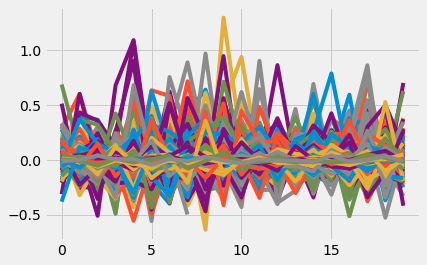

4848

In [178]:
a = clusters_data_list3[2]
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
        coeffs = pywt.wavedec(grpah, 'db1', level=1)
        plt.plot(coeffs[0])
    except:
        pass
plt.rcParams["figure.figsize"] = (16,10)
plt.show()
len(a)

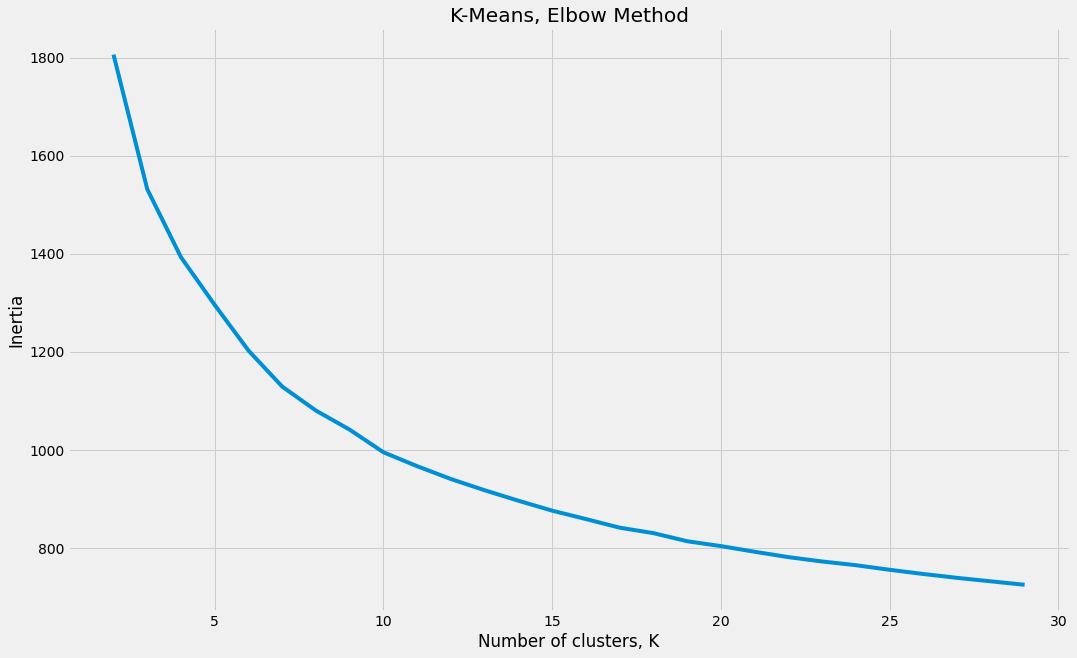

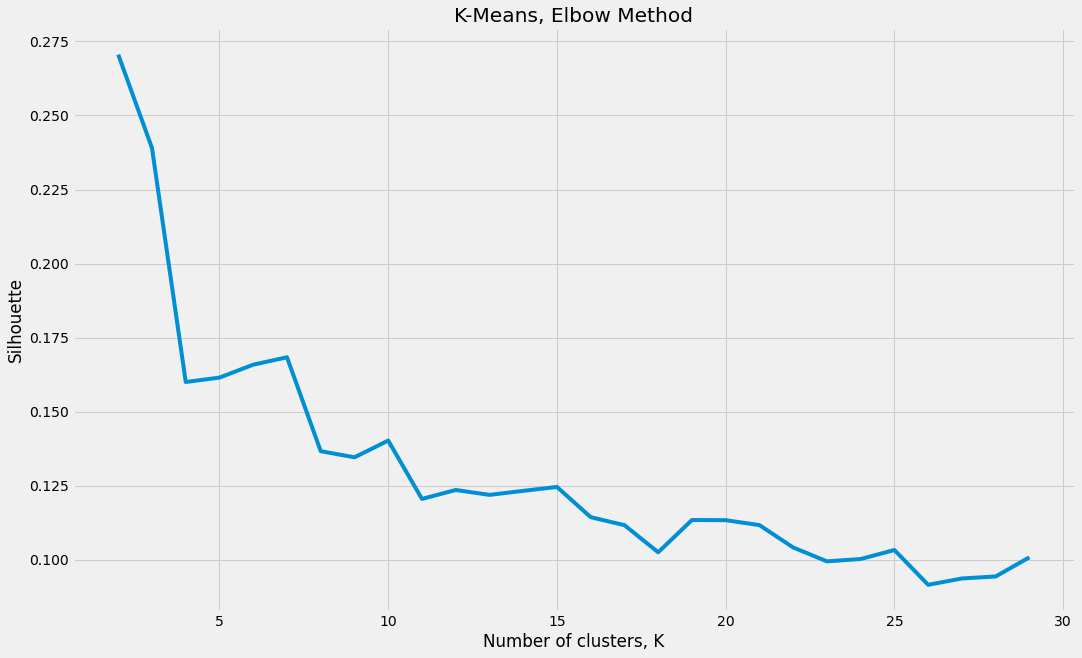

In [180]:
from sklearn.metrics import silhouette_score
inertias = {}
silhouettes = {}
for k in range(2, 30):
    kmeans = KMeans(init='k-means++', n_init=10, n_clusters=k, max_iter=1000, random_state=42).fit(data_scaled)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(data_scaled, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.grid(True);
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

In [ ]:
data = {}
l = []
a = clusters_data_list2[0]
for c in a['SecurityID']:
    graph = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
    if len(graph) == 40:
        data[c] = graph
        l.append(c)

In [ ]:
df = pd.DataFrame(data,columns=l)

corrMatrix = df.corr()
print (corrMatrix)